# `xvr` tutorial

1. Connect to a GPU: `Runtime > Change runtime type > T4 GPU`
2. Install `xvr`
3. Download data and pretrained models

In [1]:
!pip install git+https://github.com/eigenvivek/xvr.git --upgrade

  Cloning https://github.com/eigenvivek/xvr.git to c:\users\aksha\appdata\local\temp\pip-req-build-7tiidtie
  Resolved https://github.com/eigenvivek/xvr.git to commit 3e0b26eb51ef4a9c37615611bb05e0e200e48092
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/xvr.git 'C:\Users\aksha\AppData\Local\Temp\pip-req-build-7tiidtie'


In [2]:
!pip install git+https://github.com/eigenvivek/DiffDRR.git

!pip install nibabel pydicom matplotlib tqdm


  Cloning https://github.com/eigenvivek/DiffDRR.git to c:\users\aksha\appdata\local\temp\pip-req-build-f0nm5yur
  Resolved https://github.com/eigenvivek/DiffDRR.git to commit 13a9a224db3005348f174a349aea9774d500aac5
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for diffdrr: filename=diffdrr-0.6.0rc2-py3-none-any.whl size=34803488 sha256=a51443104f988072e61af3d863d37e87fe9ff78b244ba482e2f988e9b07abe28
  Stored in directory: C:\Users\aksha\AppData\Local\Temp\pip-ephem-wheel-cache-_hib8c7i\wheels\f9\4d\08\e671879ba0756c04e4fb542589af1446614e9a529a6f781dd1
Successfully built diffdrr
  Attempting uninstall: diffdrr
    Found existing installation: diffdrr 0.5.1
    Uninstalling diffdrr-0.5.1:
      Successfully uninstalled diffdrr-0.5.1


  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/DiffDRR.git 'C:\Users\aksha\AppData\Local\Temp\pip-req-build-f0nm5yur'
  DEPRECATION: Building 'diffdrr' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'diffdrr'. Discussion can be found at https://github.com/pypa/pip/issues/6334


## Install `xvr`

In [3]:
!xvr --version

xvr, version 0.0.0rc1


## Test-time optimization

Here, we show how to iteratively refine the initial poses estimated by a patient-specific neural network.

In [ ]:
# !HF_HUB_DISABLE_PROGRESS_BARS=TRUE

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [225]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffdrr.pose import RigidTransform
from huggingface_hub import snapshot_download

from xvr.metrics import Evaluator
from xvr.registrar import RegistrarModel
from xvr.utils import XrayTransforms
from xvr.visualization import plot_registration

In [226]:
import matplotlib.pyplot as plt
import torch
from diffdrr.visualization import plot_drr
from xvr.metrics import Evaluator
from xvr.utils import XrayTransforms
from diffdrr.pose import RigidTransform

def plot_registration(drr, fiducials, gt, pred_pose, true_pose):
    # ✅ Force detector origin to center
    drr.set_intrinsics_(x0=0.0, y0=0.0)

    # No axis flipping here
    flipped_pose = RigidTransform(matrix=pred_pose.matrix.clone())

    # # Step 1: Flip a copy of the predicted pose for fiducial projection & evaluation
    # flipped_pose = RigidTransform(matrix=pred_pose.matrix.clone())
    # flipped_pose.matrix[0, 0, 3] *= -1  # Flip X translation
    # flipped_pose.matrix[0, 1, 3] *= -1  # Flip Y translation
    # # flipped_pose.matrix[0, 2, 3] *= -1  # Flip Z translation

    evaluator = Evaluator(drr, fiducials)
    mtre = evaluator(true_pose, flipped_pose)[2]

    with torch.no_grad():
        pred_img = drr(pred_pose).cpu()
        true_img = drr(true_pose).cpu()
        error = (true_img - pred_img)

        pred_pts = drr.perspective_projection(flipped_pose, fiducials).cpu().squeeze()
        true_pts = drr.perspective_projection(true_pose, fiducials).cpu().squeeze()

    xt = XrayTransforms(drr.detector.height, drr.detector.width)
    gt = xt(gt)
    pred_img = xt(pred_img)

    axs = plot_drr(torch.concat([pred_img, gt, error]))
    axs[1].scatter(true_pts[..., 0], true_pts[..., 1], color="dodgerblue", label="True")
    axs[1].scatter(pred_pts[..., 0], pred_pts[..., 1], color="darkorange", label="Pred")
    for x, y in zip(pred_pts, true_pts):
        axs[1].plot([x[0], y[0]], [x[1], y[1]], "w--", linewidth=0.8)
    axs[1].legend()

    plot_drr(
        torch.concat([pred_img, gt, error]),
        title=[
            "DRR from Predicted Pose",
            "Ground truth X-ray",
            f"Error (mTRE = {mtre:.2f} mm)"
        ],
        ticks=False,
        axs=axs,
    )

    axs[2].imshow(
        error[0].permute(1, 2, 0),
        cmap="bwr",
        vmin=-error.abs().max(),
        vmax=error.abs().max()
    )

    plt.tight_layout()
    plt.show()


## Evaluating pretrained models

Here, we are using the pretrained models and testing them using our Femur CT data and x ray image to find the pose value.

In [227]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Model Evaluation

In [295]:
true_pose = torch.load("xray_pose.pt", weights_only=False).cuda()
print("True Pose:",true_pose.matrix)

True Pose: tensor([[[ 9.6593e-01, -2.5882e-01,  0.0000e+00,  1.8117e+02],
         [ 2.5882e-01,  9.6593e-01,  0.0000e+00, -6.7615e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.5000e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')


In [296]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    """
    Converts a 4x4 homogeneous pose matrix to Euler angles and translation vector.

    Args:
        pose_matrix (torch.Tensor): shape [4, 4] or [1, 4, 4]
        convention (str): e.g., "ZXY"
        degrees (bool): Return angles in degrees (True) or radians (False)

    Returns:
        euler_angles (torch.Tensor): shape [3] (rx, ry, rz)
        translation (torch.Tensor): shape [3] (x, y, z)
    """
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(true_pose.matrix, convention="ZXY", degrees=True)
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Rotation angles (ZXY) in degrees: tensor([15.,  0.,  0.])
Translation (mm): tensor([ 181.1733, -676.1481,  150.0000])


In [297]:
# Load the ground truth 3D fiducials
fiducials = torch.load("xray_fiducials.pt", weights_only=False).cuda()
# fiducials = fiducials.unsqueeze(0)  # Adds a batch dimension at dim=0

In [298]:
print("Fiducials",fiducials)

Fiducials tensor([[[ -35.7185,  301.0121,  177.3211],
         [ -26.4762,  303.4886,  188.5535],
         [ -26.4762,  303.4886,  204.3620],
         [ -30.8964,  302.3042,  216.0104],
         [ -42.1479,  299.2894,  225.9947],
         [ -63.4453,  293.5828,  224.7467],
         [ -76.3042,  290.1372,  205.1940],
         [ -92.7796,  285.7227,  199.3698],
         [-114.4789,  279.9083,  204.7780],
         [-125.7304,  276.8936,  175.2410],
         [-121.7120,  277.9703,  160.2645],
         [-110.0586,  281.0928,  134.4716],
         [-105.2366,  282.3848,   86.6300],
         [-102.8255,  283.0308,   43.3645],
         [ -99.2090,  283.9999,    5.0912],
         [ -65.8564,  292.9367,    7.5873],
         [ -67.0619,  292.6137,   29.2200],
         [ -68.6693,  292.1830,   49.1887],
         [ -70.2766,  291.7523,   72.9015],
         [ -71.0803,  291.5370,   94.9503],
         [ -69.8748,  291.8600,  120.3271],
         [ -64.2490,  293.3674,  139.4638],
         [ -66.6601,  

Dataset.file_meta -------------------------------
(0002,0002) Media Storage SOP Class UID         UI: X-Ray Angiographic Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.10741121823662646197357557142725376537
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.4.4'
-------------------------------------------------
(0008,0016) SOP Class UID                       UI: X-Ray Angiographic Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.10741121823662646197357557142725376537
(0008,0020) Study Date                          DA: '20250902'
(0008,0030) Study Time                          TM: '162141'
(0008,0060) Modality                            CS: 'OT'
(0010,0010) Patient's Name                      PN: 'Synthetic'
(0010,0020) Patient ID   

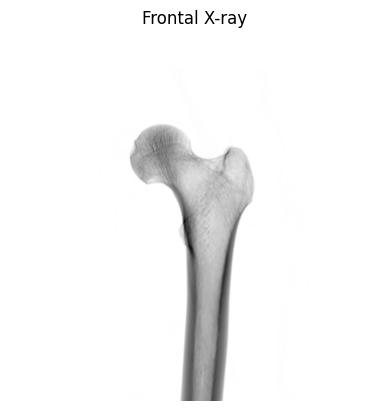

In [299]:
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path

dicom_img = pydicom.dcmread("xray_image.dcm")

# Print metadata
print(dicom_img)

# Display the image
plt.imshow(dicom_img.pixel_array, cmap='gray')
plt.title("Frontal X-ray")
plt.axis('off')
plt.show()


In [300]:
model_agnostic = RegistrarModel(
        volume="SE000002.nii",
        mask=None,
        # ckptpath="trained-new-paths/finetuned02_10ep.pth",
        # ckptpath = "/content/drive/MyDrive/Trained Registration model/Finetuned/Agnostic Fine tuned Default Parameter/xvr_0005.pth", # Best for full bone
        #ckptpath = "RXVR_Finetuned\RXVR1.1_Finetuned_01_0001.pth ",
        ckptpath = "RXVR_Finetuned\output_current-model_finetuned_0.001\RXVR1.2_Finetuned_04_0020.pth",
        # ckptpath = "C:/Users/aksha/Robossis/output_trained/RXVR1.1_best.pth","
        crop=0,
        init_only=False,
        reverse_x_axis=True,
    )

# # Step 2: Force override orientation (since it's loaded from checkpoint by default)
# model_agnostic.config["orientation"] = "PA"  # ✅ Force PA to match your DRRs
# model_agnostic.orientation = "PA"            # ✅ Also overwrite the actual registrar attribute

In [301]:
import torchio as tio

ct = tio.ScalarImage("SE000002.nii")
origin = ct.affine[:3, 3]
print("✅ CT origin from TorchIO (evaluation):", origin)

✅ CT origin from TorchIO (evaluation): [  12.           88.         -467.18499756]


In [302]:
# import pydicom

# # Load your C-arm DICOM file
# filename = "C_Arm/1.2.840.113780.9800.8251012.20250716145723.3.40.dcm"  # Update this path if needed
# ds = pydicom.dcmread(filename)

# # Set the missing attribute
# ds.DistanceSourceToDetector = 1000  # Replace 1000 with your actual sdd value in mm

# # Optional: make sure PixelSpacing is present and valid
# if "PixelSpacing" not in ds:
#     ds.PixelSpacing = [0.316, 0.316]  # based on your delx

# # Save the updated DICOM
# ds.save_as(filename)
# print("DICOM updated with SDD and saved.")


In [303]:
# print(ds.DistanceSourceToDetector)
# print(ds.PixelSpacing)


In [304]:
# Demonstrate the patient-agnostic model
gt, _, drr, init_pose, final_pose, _ = model_agnostic.run("xray_image.dcm", beta=0.5)

Stage 1:  26%|██████████▎                            | 132/500 [00:02<00:07, 49.99it/s, ncc = 0.685]


## INIT_POSE ICP Logic

In [305]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation as R

def icp_rigid_transform_init(A: torch.Tensor, B: torch.Tensor):
    """
    Estimate R, t that aligns A (Nx3) to B (Nx3)
    Returns a 4x4 homogeneous transformation matrix
    """
    assert A.shape == B.shape, "Predicted and true points must be same shape"

    centroid_A = A.mean(dim=0)
    centroid_B = B.mean(dim=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = AA.T @ BB
    U, S, Vt = torch.linalg.svd(H)
    R_ = Vt.T @ U.T

    if torch.det(R_) < 0:
        Vt[-1, :] *= -1
        R_ = Vt.T @ U.T

    t_ = centroid_B - R_ @ centroid_A

    # Convert to 4x4 pose matrix
    T = torch.eye(4)
    T[:3, :3] = R_
    T[:3, 3] = t_

    return T


In [306]:
with torch.no_grad():
    device = drr.device
    pred_pts_2d = drr.perspective_projection(init_pose, fiducials).squeeze().to(device)
    true_pts_2d = drr.perspective_projection(true_pose, fiducials).squeeze().to(device)

# Project back to 3D using known pose and intrinsics
pred_pts_3d = drr.inverse_projection(init_pose, pred_pts_2d.unsqueeze(0)).squeeze()
true_pts_3d = drr.inverse_projection(true_pose, true_pts_2d.unsqueeze(0)).squeeze()


In [307]:
from diffdrr.pose import RigidTransform

T_icp = icp_rigid_transform_init(pred_pts_3d, true_pts_3d)

# Apply correction
corrected_pose_matrix = T_icp @ init_pose.matrix[0].detach().cpu()
corrected_pose = RigidTransform(matrix=corrected_pose_matrix.unsqueeze(0).to(drr.device))
corrected_pose.matrix[0] = corrected_pose_matrix

torch.save(corrected_pose, "pose_corrected_init.pt")
print("✅ Pose corrected using ICP and saved.")


✅ Pose corrected using ICP and saved.


📐 Corrected mTRE = 48.68 mm


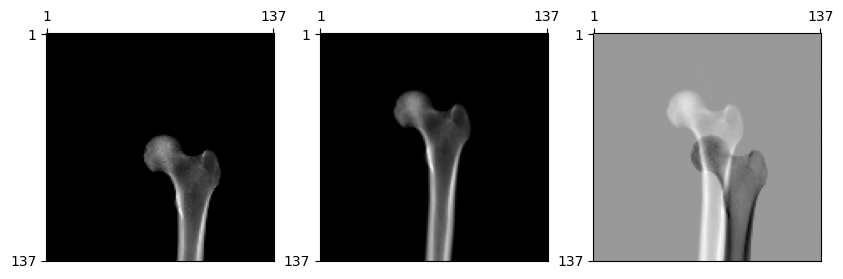

In [308]:
from xvr.visualization import plot_drr
from xvr.metrics import Evaluator

device = drr.device

# Generate corrected DRR
corrected_img = drr(corrected_pose).cpu()

# Apply consistent image transforms
xt = XrayTransforms(drr.detector.height, drr.detector.width)
gt = xt(gt)  # ✅ this was missing
corrected_img = xt(corrected_img)

# Compute error and plot
error_corrected = (gt - corrected_img)
axs = plot_drr(torch.concat([corrected_img, gt, error_corrected]))

# Evaluate corrected mTRE
evaluator = Evaluator(drr, fiducials)
mtre_corrected = evaluator(true_pose, corrected_pose)[2]
print(f"📐 Corrected mTRE = {mtre_corrected:.2f} mm")


## FINAL_POSE ICP Logic

In [309]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation as R

def icp_rigid_transform_final(A: torch.Tensor, B: torch.Tensor):
    """
    Estimate R, t that aligns A (Nx3) to B (Nx3)
    Returns a 4x4 homogeneous transformation matrix
    """
    assert A.shape == B.shape, "Predicted and true points must be same shape"

    centroid_A = A.mean(dim=0)
    centroid_B = B.mean(dim=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = AA.T @ BB
    U, S, Vt = torch.linalg.svd(H)
    R_ = Vt.T @ U.T

    if torch.det(R_) < 0:
        Vt[-1, :] *= -1
        R_ = Vt.T @ U.T

    t_ = centroid_B - R_ @ centroid_A

    # Convert to 4x4 pose matrix
    T = torch.eye(4)
    T[:3, :3] = R_
    T[:3, 3] = t_

    return T


In [310]:
with torch.no_grad():
    device = drr.device
    pred_pts_2d = drr.perspective_projection(final_pose, fiducials).squeeze().to(device)
    true_pts_2d = drr.perspective_projection(true_pose, fiducials).squeeze().to(device)

# Project back to 3D using known pose and intrinsics
pred_pts_3d = drr.inverse_projection(final_pose, pred_pts_2d.unsqueeze(0)).squeeze()
true_pts_3d = drr.inverse_projection(true_pose, true_pts_2d.unsqueeze(0)).squeeze()


In [311]:
from diffdrr.pose import RigidTransform

T_icp = icp_rigid_transform_final(pred_pts_3d, true_pts_3d)

# Apply correction
corrected_pose_matrix = T_icp @ final_pose.matrix[0].detach().cpu()
corrected_pose = RigidTransform(matrix=corrected_pose_matrix.unsqueeze(0).to(drr.device))
corrected_pose.matrix[0] = corrected_pose_matrix

torch.save(corrected_pose, "pose_corrected_final.pt")
print("✅ Pose corrected using ICP and saved.")


✅ Pose corrected using ICP and saved.


📐 Corrected mTRE = 2.09 mm


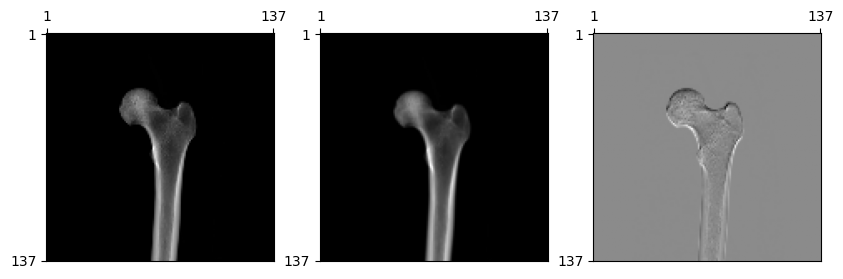

In [312]:
from xvr.visualization import plot_drr
from xvr.metrics import Evaluator

device = drr.device

# Generate corrected DRR
corrected_img = drr(corrected_pose).cpu()

# Apply consistent image transforms
xt = XrayTransforms(drr.detector.height, drr.detector.width)
gt = xt(gt)  # ✅ this was missing
corrected_img = xt(corrected_img)

# Compute error and plot
error_corrected = (gt - corrected_img)
axs = plot_drr(torch.concat([corrected_img, gt, error_corrected]))

# Evaluate corrected mTRE
evaluator = Evaluator(drr, fiducials)
mtre_corrected = evaluator(true_pose, corrected_pose)[2]
print(f"📐 Corrected mTRE = {mtre_corrected:.2f} mm")


In [313]:
print("GT shape:", gt.shape)
print("Corrected shape:", corrected_img.shape)


GT shape: torch.Size([1, 1, 137, 137])
Corrected shape: torch.Size([1, 1, 137, 137])


In [314]:
print(gt.shape)
print(type(gt))

torch.Size([1, 1, 137, 137])
<class 'torch.Tensor'>


In [315]:
print("Initial Pose:",init_pose.matrix)
print(type(init_pose))

Initial Pose: tensor([[[ 9.8080e-01, -1.9069e-01,  4.0819e-02,  1.3641e+02],
         [ 1.9449e-01,  9.7186e-01, -1.3292e-01, -6.8498e+02],
         [-1.4323e-02,  1.3831e-01,  9.9029e-01,  5.2093e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
<class 'diffdrr.pose.RigidTransform'>


In [316]:
print("Final Pose:",final_pose.matrix)
print(type(final_pose))

Final Pose: tensor([[[ 9.6585e-01, -2.5910e-01, -2.3940e-03,  1.8184e+02],
         [ 2.5911e-01,  9.6583e-01,  5.1789e-03, -6.7796e+02],
         [ 9.7033e-04, -5.6223e-03,  9.9998e-01,  1.5371e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', grad_fn=<CopySlices>)
<class 'diffdrr.pose.RigidTransform'>


In [317]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=False):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(init_pose.matrix, convention="ZXY", degrees=False)
# Output
print("Predicted 6 DOF Initial Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Initial Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([0.1975, 0.1333, 0.0412])
Translation (mm): tensor([ 136.4088, -684.9791,   52.0932])


In [318]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].detach().cpu().numpy()
    t_vec = pose_matrix[:3, 3].detach().cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(final_pose.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF Final Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Final Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([15.0177, -0.2967, -0.1372])
Translation (mm): tensor([ 181.8419, -677.9581,  153.7090])


In [319]:
pose_corrected_init = torch.load("pose_corrected_init.pt", weights_only=False).cuda()
print("pose_corrected_init:",pose_corrected_init.matrix)

pose_corrected_init: tensor([[[ 9.6587e-01, -2.5882e-01,  1.0629e-02,  2.0270e+02],
         [ 2.5880e-01,  9.6593e-01,  2.8480e-03, -6.7038e+02],
         [-1.1004e-02,  5.5134e-07,  9.9994e-01,  1.9167e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')


In [320]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].detach().cpu().numpy()
    t_vec = pose_matrix[:3, 3].detach().cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(pose_corrected_init.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF ICP-Init Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF ICP-Init Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([14.9991, -0.1632,  0.6090])
Translation (mm): tensor([ 202.6993, -670.3797,  191.6652])


In [321]:
pose_corrected_final = torch.load("pose_corrected_final.pt", weights_only=False).cuda()
print("pose_corrected_final:",pose_corrected_final.matrix)

pose_corrected_final: tensor([[[ 9.6593e-01, -2.5882e-01, -9.4566e-04,  1.8105e+02],
         [ 2.5882e-01,  9.6593e-01, -2.5324e-04, -6.7618e+02],
         [ 9.7896e-04, -2.2491e-07,  1.0000e+00,  1.4801e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', requires_grad=True)


In [334]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].detach().cpu().numpy()
    t_vec = pose_matrix[:3, 3].detach().cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(pose_corrected_final.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF ICP-Final Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF ICP-Final Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([ 1.5000e+01,  1.4507e-02, -5.4182e-02])
Translation (mm): tensor([ 181.0499, -676.1810,  148.0056])


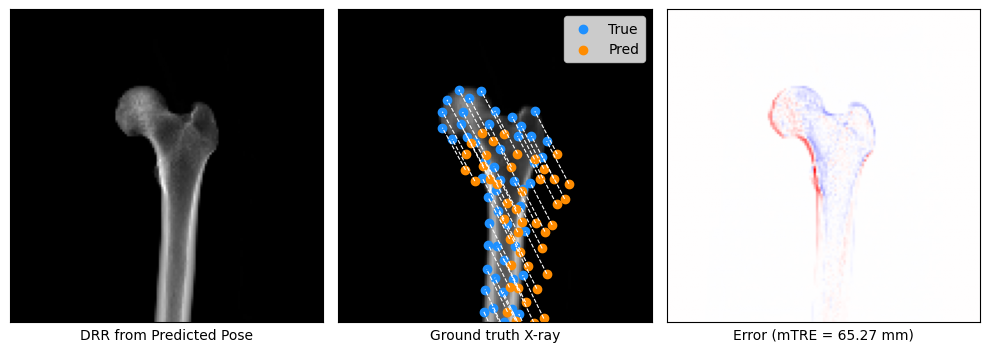

In [335]:
plot_registration(drr, fiducials, gt, init_pose, true_pose)

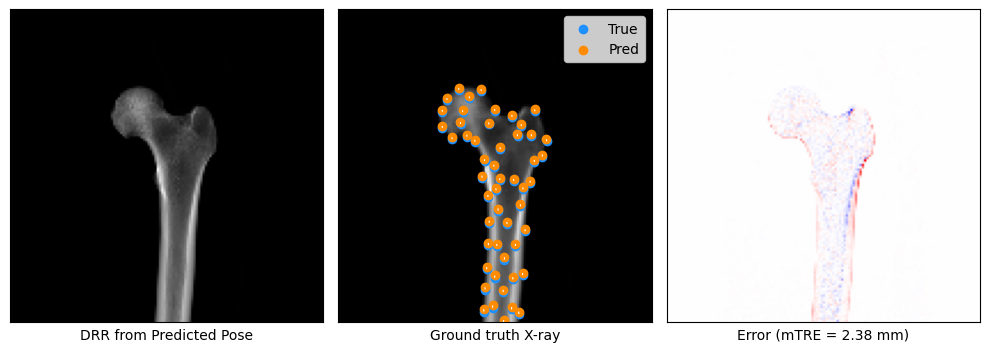

In [336]:
plot_registration(drr, fiducials, gt, final_pose, true_pose)

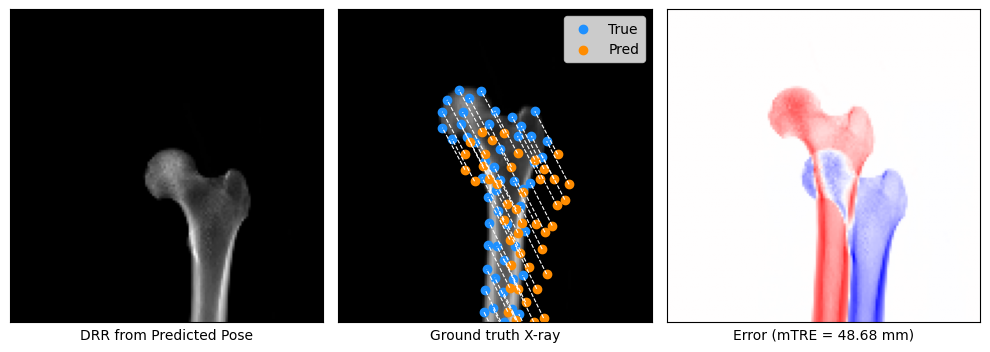

In [337]:
plot_registration(drr, fiducials, gt, pose_corrected_init, true_pose)

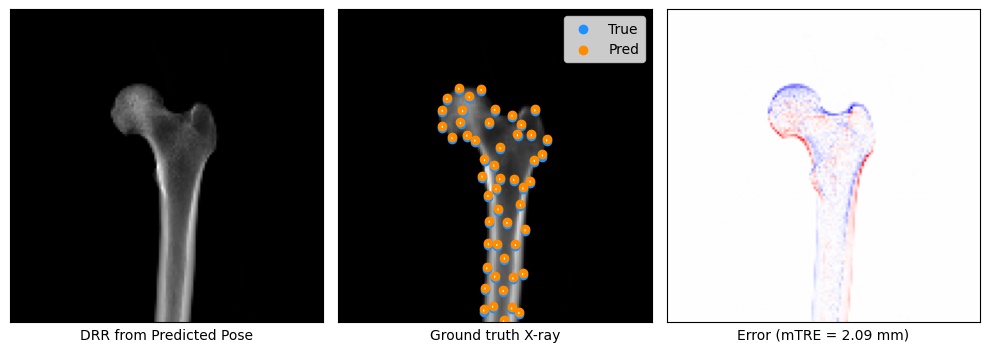

In [338]:
plot_registration(drr, fiducials, gt, pose_corrected_final, true_pose)

In [327]:
from diffdrr.pose import RigidTransform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pose_axes(pose, label, ax, color='blue'):
    origin = pose.matrix[0, :3, 3].detach().cpu().numpy()
    R = pose.matrix[0, :3, :3].detach().cpu().numpy()
    axes = R @ np.eye(3) * 50  # scale = 50 mm

    for i, c in enumerate(['r', 'g', 'b']):  # X, Y, Z
        ax.quiver(*origin, *axes[:, i], color=c, label=f'{label} {["X","Y","Z"][i]}')

    ax.scatter(*origin, color=color, s=30)
    ax.text(*origin, label, color=color)


def plot_all_poses(init_pose, final_pose, true_pose):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    plot_pose_axes(init_pose, "Init", ax, 'orange')
    plot_pose_axes(final_pose, "Final", ax, 'green')
    plot_pose_axes(true_pose, "True", ax, 'blue')

    ax.set_xlim(-500, 500)
    ax.set_ylim(-1000, 0)
    ax.set_zlim(0, 300)
    ax.set_xlabel("X axis (mm)")
    ax.set_ylabel("Y axis (mm)")
    ax.set_zlabel("Z axis (mm)")
    ax.set_title("Pose Comparison")
    ax.legend()
    plt.tight_layout()
    plt.show()


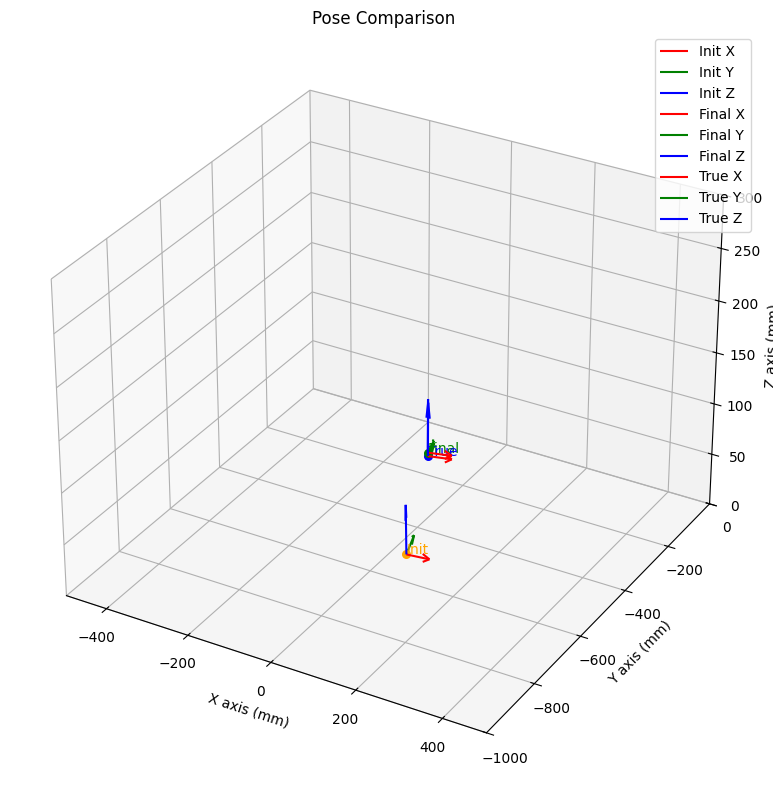

In [328]:
plot_all_poses(init_pose, final_pose, true_pose)

In [329]:
from diffdrr.pose import RigidTransform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pose_axes(pose, label, ax, color='blue'):
    origin = pose.matrix[0, :3, 3].detach().cpu().numpy()
    R = pose.matrix[0, :3, :3].detach().cpu().numpy()
    axes = R @ np.eye(3) * 50  # scale = 50 mm

    for i, c in enumerate(['r', 'g', 'b']):  # X, Y, Z
        ax.quiver(*origin, *axes[:, i], color=c, label=f'{label} {["X","Y","Z"][i]}')

    ax.scatter(*origin, color=color, s=30)
    ax.text(*origin, label, color=color)


def plot_all_poses(init_pose, final_pose, true_pose):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    plot_pose_axes(pose_corrected_init, "Init", ax, 'orange')
    plot_pose_axes(pose_corrected_final, "Final", ax, 'green')
    plot_pose_axes(true_pose, "True", ax, 'blue')

    ax.set_xlim(-500, 500)
    ax.set_ylim(-1000, 0)
    ax.set_zlim(0, 300)
    ax.set_xlabel("X axis (mm)")
    ax.set_ylabel("Y axis (mm)")
    ax.set_zlabel("Z axis (mm)")
    ax.set_title("Pose Comparison")
    ax.legend()
    plt.tight_layout()
    plt.show()


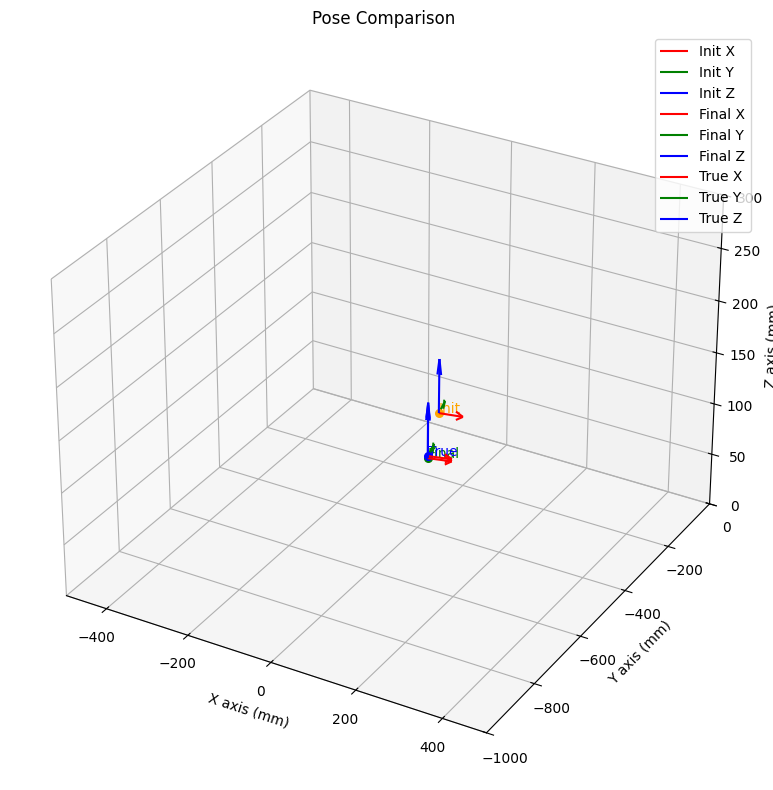

In [330]:
plot_all_poses(pose_corrected_init, pose_corrected_final, true_pose)

In [331]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D

# # Replace these with your actual torch.Tensor RigidTransform matrices:
# final_pose = torch.tensor([[[ 9.9840e-01, -5.6383e-02,  5.0787e-03,  3.9603e+01],
#                              [ 5.5634e-02,  9.9380e-01,  9.6283e-02, -6.6946e+02],
#                              [-1.0476e-02, -9.5846e-02,  9.9534e-01,  1.6945e+02],
#                              [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

# true_pose = torch.tensor([[[ 1.0000,  0.0000,  0.0000,     0.0000],
#                             [ 0.0000,  1.0000,  0.0000,  -700.0000],
#                             [ 0.0000,  0.0000,  1.0000,   150.0000],
#                             [ 0.0000,  0.0000,  0.0000,     1.0000]]])

# init_pose = torch.tensor([[[ 9.9705e-01, -6.4187e-02,  4.2021e-02,   5.0838e+01],
#                             [ 6.6161e-02,  9.9668e-01, -4.7408e-02, -6.9660e+02],
#                             [-3.8839e-02,  5.0048e-02,  9.9799e-01,   6.2435e+01],
#                             [ 0.0000e+00,  0.0000e+00,  0.0000e+00,   1.0000e+00]]])


# def plot_pose_axes(pose, label, ax, scale=50):
#     R = pose[0, :3, :3].detach().numpy()
#     t = pose[0, :3, 3].detach().numpy()

#     # Unit axis vectors scaled for display
#     x = R @ np.array([1, 0, 0]) * scale
#     y = R @ np.array([0, 1, 0]) * scale
#     z = R @ np.array([0, 0, 1]) * scale

#     ax.quiver(*t, *x, color='red')
#     ax.quiver(*t, *y, color='green')
#     ax.quiver(*t, *z, color='blue')
#     ax.text(*(t + 1.5 * z), f'{label}', fontsize=10)


# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# plot_pose_axes(init_pose, 'Init', ax)
# plot_pose_axes(final_pose, 'Final', ax)
# plot_pose_axes(true_pose, 'True', ax)

# ax.set_xlim(-200, 200)
# ax.set_ylim(-1000, -400)
# ax.set_zlim(0, 300)

# ax.set_xlabel("X (Left → Right)")
# ax.set_ylabel("Y (Head → Feet)")
# ax.set_zlabel("Z (Patient → Camera)")
# ax.set_title("📷 3D Visualization of Init / Final / True Pose")
# plt.tight_layout()
# plt.show()


In [332]:
# import torch
# import matplotlib.pyplot as plt
# from diffdrr.drr import DRR
# from diffdrr.data import read

# # --- Basic Setup (from your script) ---
# device = 'cpu'
# sdd = 1000
# height = 980
# width = 980
# delx = 0.31608
# ct_path = "SE000002.nii" # Change this to your CT path

# subject = read(ct_path, orientation='PA') # Use PA orientation as you did
# drr = DRR(subject, sdd=sdd, height=height, width=width, delx=delx).to(device)
# rot = torch.tensor([[0.0, 0.0, 0.0]], device=device)

# # --- Test Poses ---
# # Base pose (within your training distribution)
# xyz_base = torch.tensor([[0.0, -480.0, -150.0]], device=device)

# # Test poses to isolate each axis
# # xyz_test_x = torch.tensor([[100.0, -900.0, 150.0]], device=device) # Move right
# # xyz_test_y = torch.tensor([[0.0, -300.0, 150.0]], device=device) # Move "up"
# # xyz_test_z = torch.tensor([[0.0, -900.0, 300.0]], device=device) # Move closer to source (larger)

# # --- Generate DRRs ---
# img_base = drr(rot, xyz_base, parameterization="euler_angles", convention="ZXY")
# # img_x = drr(rot, xyz_test_x, parameterization="euler_angles", convention="ZXY")
# # img_y = drr(rot, xyz_test_y, parameterization="euler_angles", convention="ZXY")
# # img_z = drr(rot, xyz_test_z, parameterization="euler_angles", convention="ZXY")

# # --- Display Results ---
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# axs[0].imshow(img_base.squeeze().cpu().numpy(), cmap='gray')
# axs[0].set_title('Base Pose (ty=-900)')
# # axs[1].imshow(img_x.squeeze().cpu().numpy(), cmap='gray')
# # axs[1].set_title('Positive X-offset (moves right)')
# # axs[2].imshow(img_y.squeeze().cpu().numpy(), cmap='gray')
# # axs[2].set_title('Less Negative Y-offset (moves up)')
# # axs[3].imshow(img_z.squeeze().cpu().numpy(), cmap='gray')
# # axs[3].set_title('Positive Z-offset (moves closer/larger)')
# plt.show()

In [333]:
# import os
# import torch
# import numpy as np
# from tqdm import tqdm
# import torch.nn as nn
# from diffdrr.drr import DRR
# from diffdrr.data import read
# from diffdrr.pose import RigidTransform
# from diffdrr.metrics import MultiscaleNormalizedCrossCorrelation2d, GradientNormalizedCrossCorrelation2d
# from diffdrr.visualization import plot_drr
# from scipy.spatial import procrustes
# import matplotlib.pyplot as plt
# import pandas as pd

# # The following classes are needed for RegistrarModel and are from the provided registrar.py and drr.py
# from xvr.dicom import _parse_dicom_pose, read_xray
# from xvr.model import _correct_pose, load_model, predict_pose
# from xvr.renderer import initialize_drr
# from xvr.utils import XrayTransforms
# from diffdrr.pose import convert
# from diffdrr.registration import Registration
# from fastcore.basics import patch
# from torchio import Subject

# # You MUST place the actual definitions of your classes here, as they are not available in the notebook.
# # This is a placeholder structure based on the files you provided.
# # ---
# # from drr.py
# class Detector(nn.Module):
#     # This class is a dependency for DRR and RegistrarModel, you must define it
#     # in your code as it is not included in the provided snippets.
#     # Its functionality is implicitly used in the DRR class.
#     ...

# class DRR(nn.Module):
#     # This is a placeholder for the DRR class definition from drr.py
#     def __init__(
#         self,
#         subject: Subject,
#         sdd: float,
#         height: int,
#         delx: float,
#         width: int | None = None,
#         dely: float | None = None,
#         x0: float = 0.0,
#         y0: float = 0.0,
#         p_subsample: float | None = None,
#         reshape: bool = True,
#         reverse_x_axis: bool = True,
#         patch_size: int | None = None,
#         renderer: str = "siddon",
#         voxel_shift: float = 0.5,
#         persistent: bool = True,
#         compile_renderer: bool = False,
#         checkpoint_gradients: bool = False,
#         **renderer_kwargs,
#     ):
#         super().__init__()
#         #...
#     def forward(self, *args, parameterization: str = None, convention: str = None, calibration: RigidTransform = None, mask_to_channels: bool = False, **kwargs):
#         #...
#     def render(self, density: torch.tensor, source: torch.tensor, target: torch.tensor, mask_to_channels: bool = False, **kwargs):
#         #...
#     def set_intrinsics_(self, sdd: float = None, height: int = None, width: int = None, delx: float = None, dely: float = None, x0: float = None, y0: float = None, n_subsample: int = None, reverse_x_axis: bool = None):
#         #...
#     def rescale_detector_(self, scale: float):
#         #...
#     def perspective_projection(self, pose: RigidTransform, pts: torch.Tensor):
#         #...
#     def inverse_projection(self, pose: RigidTransform, pts: torch.Tensor):
#         #...

# # from registrar.py
# class _RegistrarBase(nn.Module):
#     # This class is a base class for RegistrarModel, you must define it
#     # in your code as it is not included in the provided snippets.
#     # Its functionality is implicitly used in the RegistrarModel class.
#     ...
#     def run(self, i2d, beta):
#         ...
#     def initialize_pose(self, i2d):
#         ...
#     def __call__(self, i2d, outpath, beta=0.5):
#         ...

# class RegistrarModel(_RegistrarBase):
#     def __init__(
#         self,
#         volume,
#         mask,
#         ckptpath,
#         labels=None,
#         crop=0,
#         subtract_background=False,
#         linearize=True,
#         reducefn="max",
#         warp=None,
#         invert=False,
#         scales="8",
#         reverse_x_axis=True,
#         renderer="trilinear",
#         parameterization="euler_angles",
#         convention="ZXY",
#         lr_rot=1e-2,
#         lr_xyz=1e0,
#         patience=10,
#         threshold=1e-4,
#         max_n_itrs=500,
#         max_n_plateaus=3,
#         init_only=False,
#         saveimg=False,
#         verbose=1,
#         read_kwargs={},
#         drr_kwargs={},
#     ):
#         # Initialize the model and its config
#         self.ckptpath = ckptpath
#         self.model, self.config, self.date = load_model(self.ckptpath, meta=True)
#         # Initial pose correction
#         self.warp = warp
#         self.invert = invert
#         super().__init__(
#             volume,
#             mask,
#             self.config["orientation"],
#             labels,
#             crop,
#             subtract_background,
#             linearize,
#             reducefn,
#             scales,
#             reverse_x_axis,
#             renderer,
#             parameterization,
#             convention,
#             lr_rot,
#             lr_xyz,
#             patience,
#             threshold,
#             max_n_itrs,
#             max_n_plateaus,
#             init_only,
#             saveimg,
#             verbose,
#             read_kwargs,
#             drr_kwargs,
#             save_kwargs={
#                 "type": "model",
#                 "ckptpath": self.ckptpath,
#                 "date": self.date,
#                 "warp": self.warp,
#                 "invert": self.invert,
#             },
#         )
#     def initialize_pose(self, i2d):
#         gt, sdd, delx, dely, x0, y0, pf_to_af = read_xray(
#             i2d, self.crop, self.subtract_background, self.linearize, self.reducefn
#         )
#         init_pose = predict_pose(self.model, self.config, gt, sdd, delx, dely, x0, y0)
#         init_pose = _correct_pose(init_pose, self.warp, self.volume, self.invert)
#         return gt, sdd, delx, dely, x0, y0, pf_to_af, init_pose
# # ---

# # Load the CT volume
# ct_path = "SE000002.nii"
# subject = read(ct_path, orientation="PA")
# volume = subject.volume.data.squeeze().to(dtype=torch.float32).cuda()
# volume_origin = subject.volume.origin.to(dtype=torch.float32).cuda()
# volume_spacing = subject.volume.spacing.to(dtype=torch.float32).cuda()

# # Set the rendering parameters
# renderer_config = {
#     "sdd": 1000.0,
#     "height": 1100,
#     "delx": 0.2816,
#     "reverse_x_axis": True,
#     "renderer": "trilinear"
# }

# # Initialize the DRR renderer
# drr = DRR(
#     volume,
#     volume_origin,
#     volume_spacing,
#     **renderer_config
# ).cuda()


# # --- Correct way to load the model with the identified class name ---
# # 1. Instantiate an empty model instance
# #    Based on registrar.py, init_only=False is the correct parameter.
# model = RegistrarModel(
#     volume=volume,
#     mask=None,
#     ckptpath="Fintetuned_Patient-Agnostic.pth",
#     init_only=False, # Corrected from `init_only_false=True` based on registrar.py
#     reverse_x_axis=True
# ).to(torch.device("cuda"))

# # 2. Load the state dictionary from your saved file
# state_dict = torch.load("Fintetuned_Patient-Agnostic.pth", map_location=torch.device("cuda"))
# model.load_state_dict(state_dict)

# # 3. Now you can set the model to evaluation mode
# model.eval()


# # --- ICP Code ---
# # Load fiducials and true pose from the .pt files
# fiducials_path = "xray_fiducials.pt"
# true_pose_path = "xray_pose.pt"

# # Load the data only if the files exist
# if os.path.exists(fiducials_path):
#     fiducials = torch.load(fiducials_path, weights_only=False).cuda()
# else:
#     fiducials = None
#     print(f"WARNING: Fiducial file not found at {fiducials_path}. Skipping ICP refinement.")

# if os.path.exists(true_pose_path):
#     true_pose = torch.load(true_pose_path, weights_only=False).cuda()
# else:
#     true_pose = None
#     print(f"WARNING: True pose file not found at {true_pose_path}. Skipping evaluation.")

# def calculate_mtre(drr_renderer, true_pose, predicted_pose, landmarks_3d):
#     """
#     Calculates the mean Target Registration Error (mTRE) by projecting 3D landmarks to 2D
#     using both true and predicted poses, and computing the average Euclidean distance.
#     """
#     if landmarks_3d is None:
#         return None

#     true_landmarks_2d = drr_renderer.perspective_projection(true_pose, landmarks_3d)
#     predicted_landmarks_2d = drr_renderer.perspective_projection(predicted_pose, landmarks_3d)
#     distances = torch.linalg.norm(true_landmarks_2d - predicted_landmarks_2d, dim=-1)
#     return distances.mean().item()

# def mark_and_backproject(
#     pose_matrix,
#     fiducial_points_2d,
#     sdd,
#     height,
#     delx,
# ):
#     """
#     Given a pose, marks fiducial points in 2D and back-projects them into 3D.
#     """
#     x_fiducial = fiducial_points_2d[..., 0].cuda()
#     y_fiducial = fiducial_points_2d[..., 1].cuda()
#     inv_pose = torch.inverse(pose_matrix.squeeze(0))
#     source = torch.zeros(1, 3).cuda()
#     source = source @ inv_pose[:3, :3] + inv_pose[3:, :3]
#     detector = torch.eye(4).cuda()
#     detector = detector @ inv_pose[:3, :3] + inv_pose[3:, :3]
#     detector_z_axis = detector[2, :3]
#     x = x_fiducial * drr.delx
#     y = y_fiducial * drr.dely
#     plane_normal = drr.detector.get_rotation()[0, 2, :]
#     ray_vector = (drr.detector.get_center()[0, :] + x[..., None] * drr.detector.get_rotation()[0, 0, :] + y[..., None] * drr.detector.get_rotation()[0, 1, :]) - drr.detector.get_source()[0, :]
#     points_3d = drr.detector.get_source()[0, :] + ray_vector * drr.sdd / (ray_vector @ drr.detector.get_rotation()[0, 2, :])
#     return points_3d.unsqueeze(0)


# def refine_pose_with_procrustes(source_points, target_points):
#     """
#     Refines a pose by aligning two sets of 3D points using Procrustes analysis (similar to ICP).
#     """
#     source_points = source_points.cpu().numpy()
#     target_points = target_points.cpu().numpy()
#     mtx1, mtx2, disparity = procrustes(source_points, target_points)
#     source_centroid = np.mean(source_points, axis=0)
#     target_centroid = np.mean(target_points, axis=0)
#     R = mtx2.T @ mtx1
#     T = source_centroid - (target_centroid @ R.T)
#     refined_pose = np.eye(4, dtype=np.float32)
#     refined_pose[:3, :3] = R.T
#     refined_pose[:3, 3] = T
#     return torch.from_numpy(refined_pose).float().cuda()

# # Main evaluation loop
# n_eval_batches = 100
# mtres = []
# mtres_icp = []

# ct_landmarks = fiducials

# if true_pose is None:
#     print("Cannot proceed without a true pose file.")
# else:
#     for _ in tqdm(range(n_eval_batches), desc="Evaluating model"):
#         random_pose = true_pose
#         initial_drr = drr(random_pose)
#         with torch.no_grad():
#             predicted_pose_matrix = model(initial_drr)

#         initial_mtres = calculate_mtre(drr, random_pose, predicted_pose_matrix, ct_landmarks)
#         if initial_mtres is not None:
#             mtres.append(initial_mtres)

#         if ct_landmarks is not None:
#             predicted_landmarks = mark_and_backproject(
#                 predicted_pose_matrix,
#                 ct_landmarks,
#                 **renderer_config
#             )

#             refined_pose_matrix = refine_pose_with_procrustes(ct_landmarks, predicted_landmarks)

#             refined_mtres = calculate_mtre(drr, random_pose, refined_pose_matrix.unsqueeze(0), ct_landmarks)
#             if refined_mtres is not None:
#                 mtres_icp.append(refined_mtres)

#     if mtres:
#         print(f"Mean mTRE (Pre-ICP): {np.mean(mtres):.4f} mm")
#     if mtres_icp:
#         print(f"Mean mTRE (Post-ICP): {np.mean(mtres_icp):.4f} mm")